Code example showing how to turn a NuSTAR evt file into a map using code from the [NuSTAR PySolar Repo](https://github.com/NuSTAR/nustar_pysolar)

**Works with SunPy v1 and v2 and the corresponding version of NuSTAR_pysolar**

In [1]:
import sys
from os.path import *
import os

from astropy.io import fits
import astropy.units as u
import astropy.time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from pylab import figure, cm
from astropy.coordinates import SkyCoord

import numpy as np
import nustar_pysolar as nustar
import sunpy.map
from scipy import ndimage

%matplotlib inline

import warnings
warnings.simplefilter('ignore')


In [2]:
# Setup the font used for plotting
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 18

In [3]:
# Load in the evt file
# dirin='/Users/iain/data/heasarc_nustar/ns_20170321/20210015001/event_cl/'
# infile = 'nu20210015001A06_cl_sunpos.evt'
dirin=''
infile = 'nu90410111001A06_cl_sunpos.evt'

# Load in the evt
hdulist = fits.open(dirin+infile)
evtdata=hdulist[1].data
hdr = hdulist[1].header
hdulist.close()

(2999.0, 1, 3000)


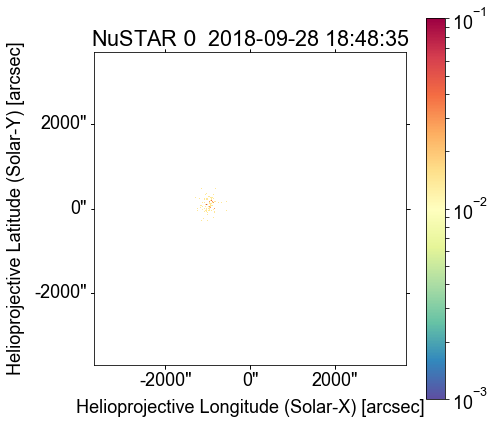

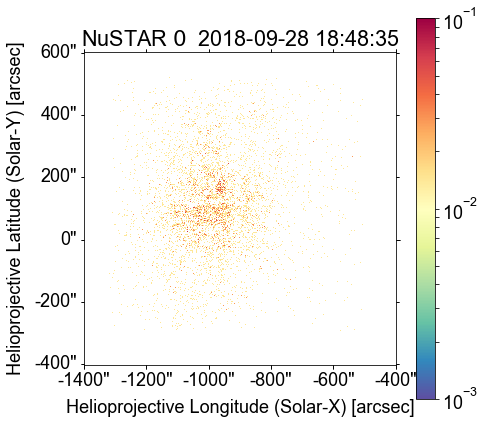

In [4]:
#  Convert into a sunpy map and plot it
nustar_map = nustar.map.make_sunpy(evtdata, hdr,norm_map=True)

bl = SkyCoord(-1400*u.arcsec, -400*u.arcsec, frame=nustar_map.coordinate_frame)
tr = SkyCoord(-400*u.arcsec, 600*u.arcsec, frame=nustar_map.coordinate_frame)
nustar_submap = nustar_map.submap(bl,tr)

dmin=1e-3
dmax=1e-1

fig = plt.figure(figsize=(7, 7))
nustar_map.plot(norm=colors.LogNorm(vmin=dmin,vmax=dmax),cmap=cm.get_cmap('Spectral_r'))
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(7, 7))
nustar_submap.plot(norm=colors.LogNorm(vmin=dmin,vmax=dmax),cmap=cm.get_cmap('Spectral_r'))
plt.colorbar()
plt.show()


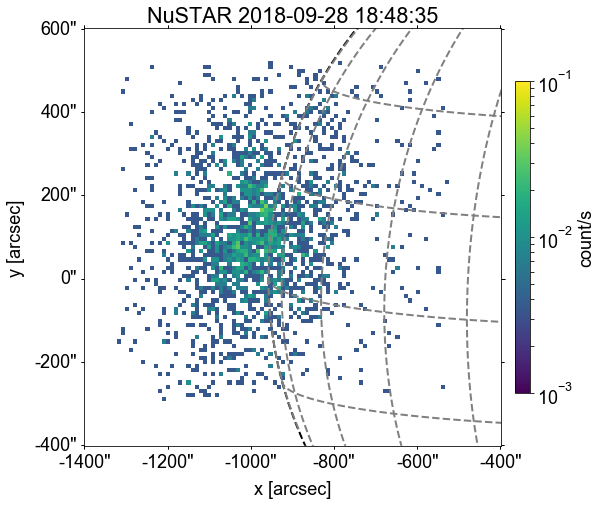

In [5]:
# Rebin the map to larger pixels and make the plot pretty
nx,ny=np.shape(nustar_submap.data)
#set to 1 means no actual rebinning
rebin_npix=4.
dimensions = u.Quantity([nx/rebin_npix, ny/rebin_npix], u.pixel)
rsn_map=nustar_submap.resample(dimensions)

dmin=1e-3
dmax=1e-1

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=rsn_map)

rsn_map.plot(norm=colors.LogNorm(vmin=dmin,vmax=dmax),cmap=plt.viridis())
rsn_map.draw_limb(color='black',linewidth=2,linestyle='dashed',zorder=0)   

# Manually plot a heliographic overlay - hopefully future no_ticks option in draw_grid
overlay = ax.get_coords_overlay('heliographic_stonyhurst')
lon = overlay[0]
lat = overlay[1]
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)
lat.set_ticklabel_visible(False)
lon.set_ticklabel_visible(False)
lon.coord_wrap = 180
lon.set_major_formatter('dd')
overlay.grid(color='grey', linewidth=2, linestyle='dashed')

# Tweak the titles and labels
title_obsdate=rsn_map.meta["date-obs"][:-4]
ax.set_title('NuSTAR '+ title_obsdate)
ax.set_ylabel('y [arcsec]')
ax.set_xlabel('x [arcsec]')
tx, ty = ax.coords
tx.set_major_formatter('s')
ty.set_major_formatter('s')
ax.grid(False)
# Add a colour bar
plt.colorbar(fraction=0.035, pad=0.03,label='count/s')

plt.show()


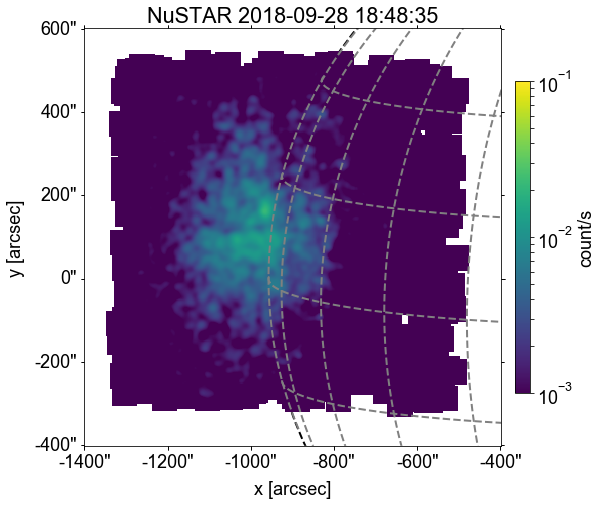

In [6]:
# Apply a gaussin blur the map and make the plot pretty
dd=ndimage.gaussian_filter(nustar_submap.data, 3, mode='nearest')
gsn_map=sunpy.map.Map(dd, nustar_submap.meta)

dmin=1e-3
dmax=1e-1

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=gsn_map)

gsn_map.plot(norm=colors.LogNorm(vmin=dmin,vmax=dmax),cmap=plt.viridis())
gsn_map.draw_limb(color='black',linewidth=2,linestyle='dashed',zorder=0)   

# Manually plot a heliographic overlay - hopefully future no_ticks option in draw_grid
overlay = ax.get_coords_overlay('heliographic_stonyhurst')
lon = overlay[0]
lat = overlay[1]
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)
lat.set_ticklabel_visible(False)
lon.set_ticklabel_visible(False)
lon.coord_wrap = 180
lon.set_major_formatter('dd')
overlay.grid(color='grey', linewidth=2, linestyle='dashed')

# Tweak the titles and labels
title_obsdate=gsn_map.meta["date-obs"][:-4]
ax.set_title('NuSTAR '+ title_obsdate)
ax.set_ylabel('y [arcsec]')
ax.set_xlabel('x [arcsec]')
tx, ty = ax.coords
tx.set_major_formatter('s')
ty.set_major_formatter('s')
ax.grid(False)
# Add a colour bar
plt.colorbar(fraction=0.035, pad=0.03,label='count/s')

plt.show()


(2999.0, 1, 3000)


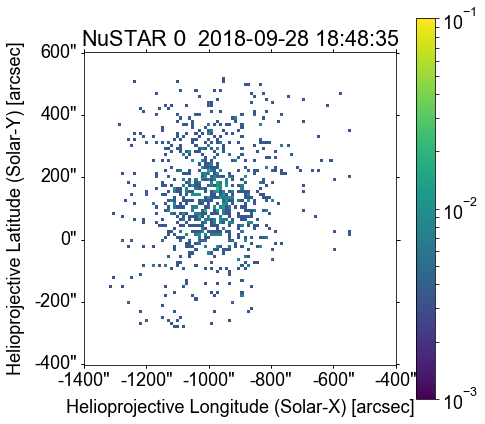

In [7]:
# Now filter the evt file to only grade 0 and remove bad pixels (default) and 2-5 keV
cleanevt = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2., energy_high=5.0)
filter_map = nustar.map.make_sunpy(cleanevt, hdr,norm_map=True)

bl = SkyCoord(-1400*u.arcsec, -400*u.arcsec, frame=filter_map.coordinate_frame)
tr = SkyCoord(-400*u.arcsec, 600*u.arcsec, frame=filter_map.coordinate_frame)
filter_submap = filter_map.submap(bl,tr)
nx,ny=np.shape(filter_submap.data)
rebin_npix=4.
dimensions = u.Quantity([nx/rebin_npix, ny/rebin_npix], u.pixel)
rfilter_submap = filter_submap.resample(dimensions)

dmin=1e-3
dmax=1e-1

fig = plt.figure(figsize=(7, 7))
rfilter_submap.plot(norm=colors.LogNorm(vmin=dmin,vmax=dmax),cmap=plt.viridis())
plt.colorbar()
plt.show()


(2999.0, 1, 3000)


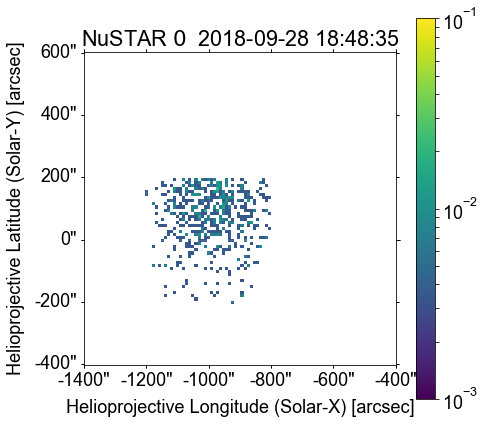

In [8]:
# Now filter the evt file to only grade 0 and remove bad pixels (default) and only x[-1200,-800]" and y[-200,200]"
cleanevt = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2., energy_high=10,\
                                     hdr=hdr,xy_range=[-1200,-800,-200,200])
filter_map = nustar.map.make_sunpy(cleanevt, hdr,norm_map=True)

bl = SkyCoord(-1400*u.arcsec, -400*u.arcsec, frame=filter_map.coordinate_frame)
tr = SkyCoord(-400*u.arcsec, 600*u.arcsec, frame=filter_map.coordinate_frame)
filter_submap = filter_map.submap(bl,tr)
nx,ny=np.shape(filter_submap.data)
rebin_npix=4.
dimensions = u.Quantity([nx/rebin_npix, ny/rebin_npix], u.pixel)
rfilter_submap = filter_submap.resample(dimensions)

dmin=1e-3
dmax=1e-1

fig = plt.figure(figsize=(7, 7))
rfilter_submap.plot(norm=colors.LogNorm(vmin=dmin,vmax=dmax),cmap=plt.viridis())
plt.colorbar()
plt.show()

(2999.0, 1, 3000)


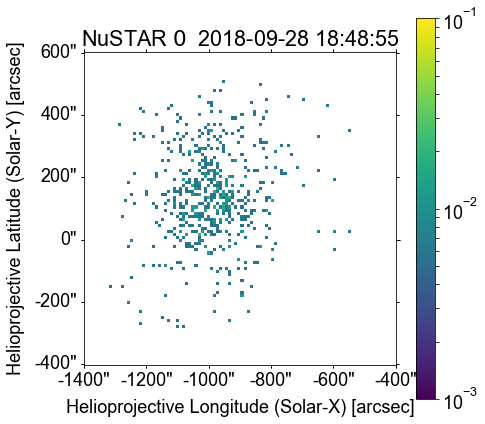

In [9]:
# Now filter the evt file to only grade 0 and remove bad pixels (default) and part of the time
time_range=astropy.time.Time(['2018-09-28T18:48:55', '2018-09-28T18:49:55'], format='isot')
cleanevt = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2., energy_high=10,\
                                     hdr=hdr,time_range=time_range)

# If doing a subset of time range and want normalise map (cnt/s) 
# need to provide exptime (in s), and ideally ontime, for that period
filter_map = nustar.map.make_sunpy(cleanevt, hdr,on_time=60 ,exp_time=60*0.7,norm_map=True)

bl = SkyCoord(-1400*u.arcsec, -400*u.arcsec, frame=filter_map.coordinate_frame)
tr = SkyCoord(-400*u.arcsec, 600*u.arcsec, frame=filter_map.coordinate_frame)
filter_submap = filter_map.submap(bl,tr)
nx,ny=np.shape(filter_submap.data)
rebin_npix=4.
dimensions = u.Quantity([nx/rebin_npix, ny/rebin_npix], u.pixel)
rfilter_submap = filter_submap.resample(dimensions)

dmin=1e-3
dmax=1e-1

fig = plt.figure(figsize=(7, 7))
rfilter_submap.plot(norm=colors.LogNorm(vmin=dmin,vmax=dmax),cmap=plt.viridis())
plt.colorbar()
plt.show()

# print(rfilter_submap.meta['exptime'],rfilter_submap.exposure_time)

<Figure size 432x288 with 0 Axes>

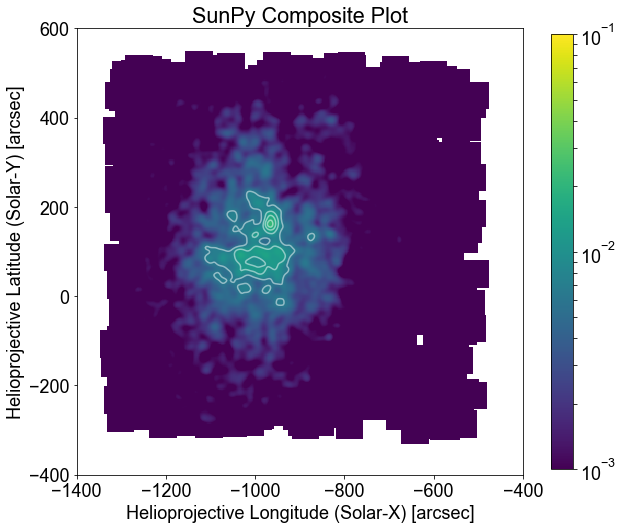

In [10]:
# Plot contours over a NuSTAR map - in this case just compositing the same map together
# but could be anything, i.e. NuSTAR contours on an AIA map

#  Make a copy of our NuSTAR map
gsn_map2=sunpy.map.Map(gsn_map.data,gsn_map.meta)

# Make a colour map with all the colours the same for plotting the contours
from matplotlib.colors import LinearSegmentedColormap
# cm2 = LinearSegmentedColormap.from_list('simple', [(0.8,0.1,0),(0.8,0.1,0)], N=2)
cm2 = LinearSegmentedColormap.from_list('simple', [(1,1,1),(1,1,1)], N=2)

# Setup up the map norm and colors and contour colours
gsn_map.plot_settings['cmap'] = plt.viridis()
gsn_map.plot_settings['norm'] = colors.LogNorm(vmin=1e-3,vmax=1e-1)
gsn_map2.plot_settings['cmap'] = cm2
# gsn_map2.plot_settings['norm'] = colors.LogNorm(vmin=dmin,vmax=dmax)

# Map the composite map
comp_map = sunpy.map.Map(gsn_map, gsn_map2, composite=True)
# Set the second map as the contours and set the limits
# comp_map.set_levels(index=1, levels=[5e-3,1e-2,1e-1])
comp_map.set_levels(index=1, levels=[30,50,70,90],percent=True)
# Change the alpha channel
comp_map.set_alpha(index=1,alpha=0.5)

fig = plt.figure(figsize=(10, 10))
comp_map.plot()
plt.colorbar(shrink=0.8)
plt.show()
